# Setup

## Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
import sys
import torch
import timm

from src.model import ModifiedModel
from src.utils import get_gflops

## Variable settings

In [29]:
sns.set_theme(style="whitegrid", context="talk")

PROJECT_ROOT = Path("../")
if str(PROJECT_ROOT.resolve()) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT.resolve()))

OUTPUTS_DIR = PROJECT_ROOT / "outputs"
LOGS_DIR = OUTPUTS_DIR / "logs"
MODELS_DIR = OUTPUTS_DIR / "models"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EXPERIMENT_NAMES = [
    "deit_full_finetune", "deit_linear_probe", "deit_static_lora", "deit_moe_lora",
    "vit_full_finetune", "vit_linear_probe", "vit_static_lora", "vit_moe_lora"
]

print(f"Setup complete. Project root: {PROJECT_ROOT.resolve()}. Using device: {DEVICE}")

Setup complete. Project root: C:\Workspace\deep-learning-final-project. Using device: cuda


## Accuracy calculation function

In [30]:
def calculate_test_accuracies(predictions_file: Path) -> tuple[float, float]:
    """
    Calculates top-1 and top-5 test accuracy from a predictions CSV.
    Args:
        predictions_file: The prediction CSV containing the top-5 predictions of a model from inference on the test set.

    Returns:
        A tuple containing the top-1 test accuracy and the top-5 test accuracy.
    """
    if not predictions_file or not predictions_file.exists():
        return 0.0, 0.0
    df = pd.read_csv(predictions_file)
    predicted_top5 = df['predicted_top5_idx'].apply(ast.literal_eval)
    true_labels = df['true_label_idx']
    top1_correct = sum(p[0] == t for p, t in zip(predicted_top5, true_labels) if p)
    top5_correct = sum(t in p for p, t in zip(predicted_top5, true_labels))
    total_predictions = len(df)
    top1_acc = (top1_correct / total_predictions) * 100 if total_predictions > 0 else 0.0
    top5_acc = (top5_correct / total_predictions) * 100 if total_predictions > 0 else 0.0
    return top1_acc, top5_acc

# Experimental Results Metrics

In [31]:
all_results = []
print("--- Parsing Experiment Results (with on-the-fly GFLOPs calculation) ---")
for exp_name in EXPERIMENT_NAMES:
    exp_log_dir = LOGS_DIR / exp_name
    print(f"Processing: {exp_name}")

    try:
        summary_path = list(exp_log_dir.glob("*_summary.json"))[0]
        with open(summary_path, 'r') as f:
            summary_data = json.load(f)

        predictions_path = exp_log_dir / "test_predictions.csv"

        model_path = MODELS_DIR / exp_name / f"best_{exp_name}_model.pth"

        # calculates GFLOPs for every model. Loads a model checkpoint, creates a dummy input, then passes them to the get_glops function.
        gflops = 0.0
        if model_path.exists():
            checkpoint = torch.load(model_path, map_location=DEVICE)
            model_config = checkpoint['model_config']
            class_names = checkpoint['class_names']
            base_model = timm.create_model(model_config['base_model_name'], pretrained=False, num_classes=len(class_names))
            model = ModifiedModel(base_model=base_model, num_classes=len(class_names), model_config=model_config)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(DEVICE)
            model.eval()
            dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
            gflops = get_gflops(model, dummy_input)
        else:
            print(f"  -> WARNING: Model file not found for {exp_name}, cannot calculate GFLOPs.")

        backbone = "DeiT-Small" if "deit" in exp_name else "ViT-Small"
        if "full_finetune" in exp_name: method = "Full Fine-Tune"
        elif "linear_probe" in exp_name: method = "Linear Probe"
        elif "moe_lora" in exp_name: method = "MoE LoRA"
        elif "static_lora" in exp_name: method = "Static LoRA"
        else: method = "Unknown"

        top1_test_acc, top5_test_acc = calculate_test_accuracies(predictions_path)

        result = {
            "Experiment": exp_name, "Backbone": backbone, "Method": method,
            "Trainable Params": summary_data.get("trainable_params", 0),
            "Trainable Pct": summary_data.get("trainable_percentage", 0),
            "GFLOPs": gflops,
            "Test Accuracy (Top 1)": top1_test_acc,
            "Test Accuracy (Top 5)": top5_test_acc,
        }
        all_results.append(result)

    except (FileNotFoundError, IndexError) as e:
        print(f"  -> SKIPPING: Could not find all required files for {exp_name}. Error: {e}")

results_df = pd.DataFrame(all_results).sort_values(by=["Backbone", "Trainable Pct"])

print("\n--- Aggregated Final Test Results ---")
display(results_df)

--- Parsing Experiment Results (with on-the-fly GFLOPs calculation) ---
Processing: deit_full_finetune


C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                                                 FLOP    % Total
------------------------------------------------  ---------  ---------
ModifiedModel                                     9197.033M    100.00%
 - aten.convolution                                115.606M      1.26%
 - aten.addmm                                     8366.100M     90.97%
 - aten._scaled_dot_product_efficient_attention    715.327M      7.78%
 ModifiedModel.base_model                         9197.033M    100.00%
  - aten.convolution                               115.606M      1.26%
  - aten.addmm                                    8366.100M     90.97%
  - aten._scaled_dot_product_efficient_attention   715.327M      7.78%
Processing: deit_linear_probe


C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                                                 FLOP    % Total
------------------------------------------------  ---------  ---------
ModifiedModel                                     9197.033M    100.00%
 - aten.convolution                                115.606M      1.26%
 - aten.addmm                                     8366.100M     90.97%
 - aten._scaled_dot_product_efficient_attention    715.327M      7.78%
 ModifiedModel.base_model                         9197.033M    100.00%
  - aten.convolution                               115.606M      1.26%
  - aten.addmm                                    8366.100M     90.97%
  - aten._scaled_dot_product_efficient_attention   715.327M      7.78%
Processing: deit_static_lora


C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                                                 FLOP    % Total
------------------------------------------------  ---------  ---------
ModifiedModel                                     9274.496M    100.00%
 - aten.convolution                                115.606M      1.25%
 - aten.addmm                                     8366.100M     90.21%
 - aten._scaled_dot_product_efficient_attention    715.327M      7.71%
 - aten.mm                                          77.464M      0.84%
 ModifiedModel.base_model                         9274.496M    100.00%
  - aten.convolution                               115.606M      1.25%
  - aten.addmm                                    8366.100M     90.21%
  - aten._scaled_dot_product_efficient_attention   715.327M      7.71%
  - aten.mm                                         77.464M      0.84%
Processing: deit_moe_lora


C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                                                 FLOP    % Total
------------------------------------------------  ---------  ---------
ModifiedModel                                     9274.496M    100.00%
 - aten.convolution                                115.606M      1.25%
 - aten.addmm                                     8368.520M     90.23%
 - aten._scaled_dot_product_efficient_attention    476.885M      5.14%
 - aten.bmm                                        313.485M      3.38%
 ModifiedModel.base_model                         9274.496M    100.00%
  - aten.convolution                               115.606M      1.25%
  - aten.addmm                                    8368.520M     90.23%
  - aten._scaled_dot_product_efficient_attention   476.885M      5.14%
  - aten.bmm                                       313.485M      3.38%
Processing: vit_full_finetune


C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                                                 FLOP    % Total
------------------------------------------------  ---------  ---------
ModifiedModel                                     9197.033M    100.00%
 - aten.convolution                                115.606M      1.26%
 - aten.addmm                                     8366.100M     90.97%
 - aten._scaled_dot_product_efficient_attention    715.327M      7.78%
 ModifiedModel.base_model                         9197.033M    100.00%
  - aten.convolution                               115.606M      1.26%
  - aten.addmm                                    8366.100M     90.97%
  - aten._scaled_dot_product_efficient_attention   715.327M      7.78%
Processing: vit_linear_probe


C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                                                 FLOP    % Total
------------------------------------------------  ---------  ---------
ModifiedModel                                     9197.033M    100.00%
 - aten.convolution                                115.606M      1.26%
 - aten.addmm                                     8366.100M     90.97%
 - aten._scaled_dot_product_efficient_attention    715.327M      7.78%
 ModifiedModel.base_model                         9197.033M    100.00%
  - aten.convolution                               115.606M      1.26%
  - aten.addmm                                    8366.100M     90.97%
  - aten._scaled_dot_product_efficient_attention   715.327M      7.78%
Processing: vit_static_lora


C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                                                 FLOP    % Total
------------------------------------------------  ---------  ---------
ModifiedModel                                     9274.496M    100.00%
 - aten.convolution                                115.606M      1.25%
 - aten.addmm                                     8366.100M     90.21%
 - aten._scaled_dot_product_efficient_attention    715.327M      7.71%
 - aten.mm                                          77.464M      0.84%
 ModifiedModel.base_model                         9274.496M    100.00%
  - aten.convolution                               115.606M      1.25%
  - aten.addmm                                    8366.100M     90.21%
  - aten._scaled_dot_product_efficient_attention   715.327M      7.71%
  - aten.mm                                         77.464M      0.84%
Processing: vit_moe_lora
Module                                                 FLOP    % Total
------------------------------------------------  --

C:\Workspace\deep-learning-final-project\src\utils.py:108: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


,Experiment,Backbone,Method,Trainable Params,Trainable Pct,GFLOPs,Test Accuracy (Top 1),Test Accuracy (Top 5)
1,deit_linear_probe,DeiT-Small,Linear Probe,18095,0.083450,9.197033,68.191489,89.787234
3,deit_moe_lora,DeiT-Small,MoE LoRA,196287,0.897848,9.274496,70.053191,91.808511
2,deit_static_lora,DeiT-Small,Static LoRA,214703,0.981259,9.274496,70.957447,91.436170
0,deit_full_finetune,DeiT-Small,Full Fine-Tune,21683759,100.000000,9.197033,72.712766,91.702128
5,vit_linear_probe,ViT-Small,Linear Probe,18095,0.083450,9.197033,65.797872,88.723404
7,vit_moe_lora,ViT-Small,MoE LoRA,196287,0.897848,9.274496,69.680851,91.436170
6,vit_static_lora,ViT-Small,Static LoRA,214703,0.981259,9.274496,69.627660,92.074468
4,vit_full_finetune,ViT-Small,Full Fine-Tune,21683759,100.000000,9.197033,72.872340,91.329787


# Plots

## Test Accuracy Plot

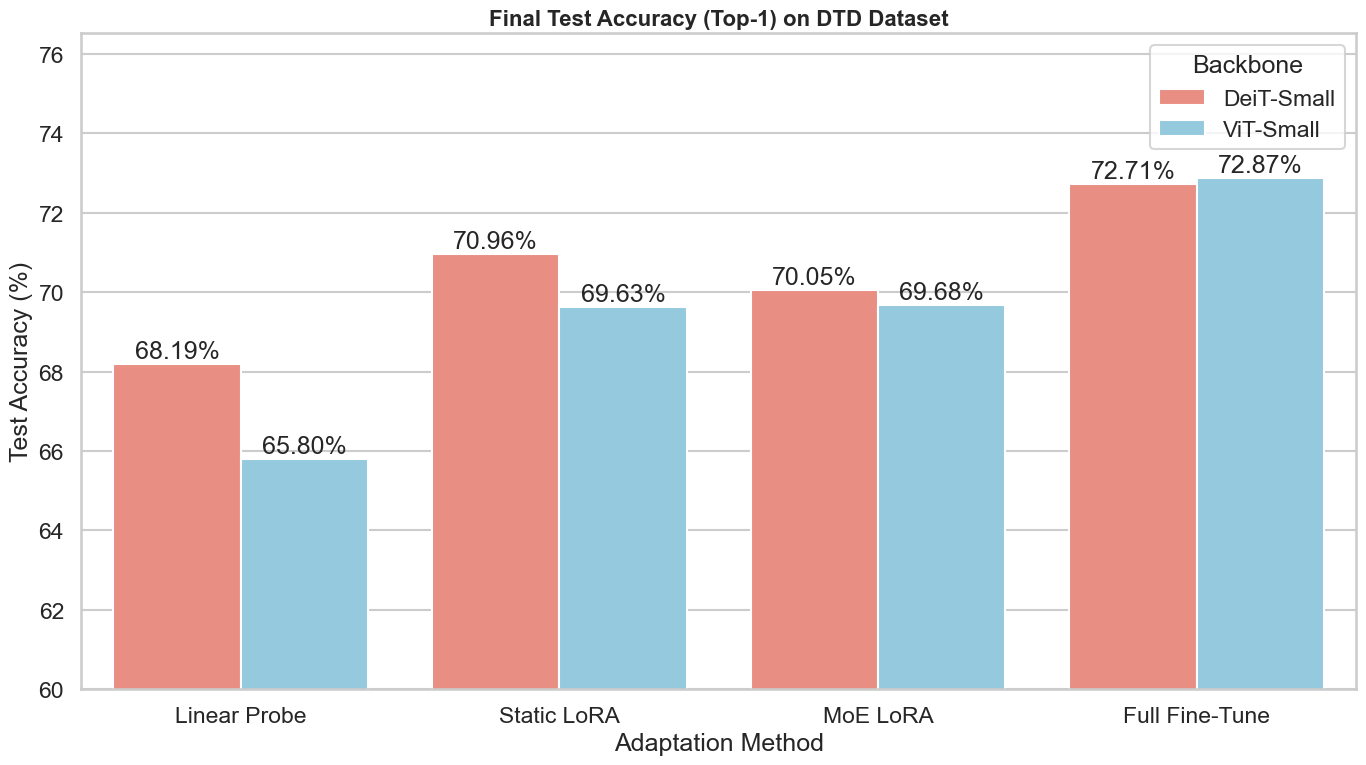

In [32]:
plt.figure(figsize=(14, 8))

ax = sns.barplot(
    data=results_df, x="Method", y="Test Accuracy (Top 1)", hue="Backbone",
    order=["Linear Probe", "Static LoRA", "MoE LoRA", "Full Fine-Tune"],
    palette={"ViT-Small": "skyblue", "DeiT-Small": "salmon"}
)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.title("Final Test Accuracy (Top-1) on DTD Dataset", fontsize=16, weight='bold')
plt.ylabel("Test Accuracy (%)")
plt.xlabel("Adaptation Method")
plt.ylim(60, results_df["Test Accuracy (Top 1)"].max() * 1.05)
plt.legend(title="Backbone")
plt.tight_layout()
plt.show()

## Test Accuracy vs Parameter Efficiency Plot

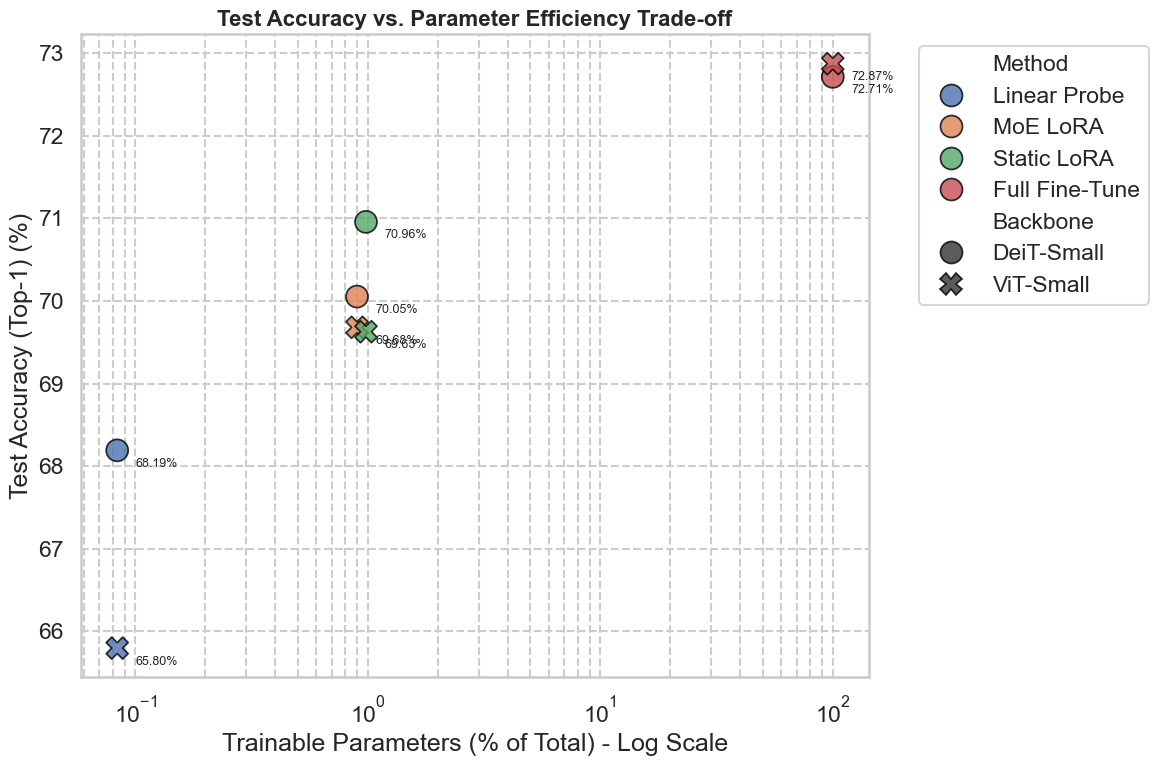

In [33]:
plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    data=results_df, x="Trainable Pct", y="Test Accuracy (Top 1)",
    hue="Method", style="Backbone", s=250, edgecolor="black", alpha=0.8
)

ax.set_xscale('log')

plt.title("Test Accuracy vs. Parameter Efficiency Trade-off", fontsize=16, weight='bold')
plt.xlabel("Trainable Parameters (% of Total) - Log Scale")
plt.ylabel("Test Accuracy (Top-1) (%)")
plt.grid(True, which="both", ls="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for i, row in results_df.iterrows():
    ax.text(row['Trainable Pct'] * 1.2, row['Test Accuracy (Top 1)'] - 0.2,
            f"{row['Test Accuracy (Top 1)']:.2f}%", fontsize=9)

plt.tight_layout()
plt.show()

## Expert Routing Visualization For MoE Models


--- Diagnostics for deit_moe_lora (DeiT-Small) ---
  Found 4 MoE layers: ['base_model.blocks.10.attn', 'base_model.blocks.11.attn', 'base_model.blocks.8.attn', 'base_model.blocks.9.attn']


C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


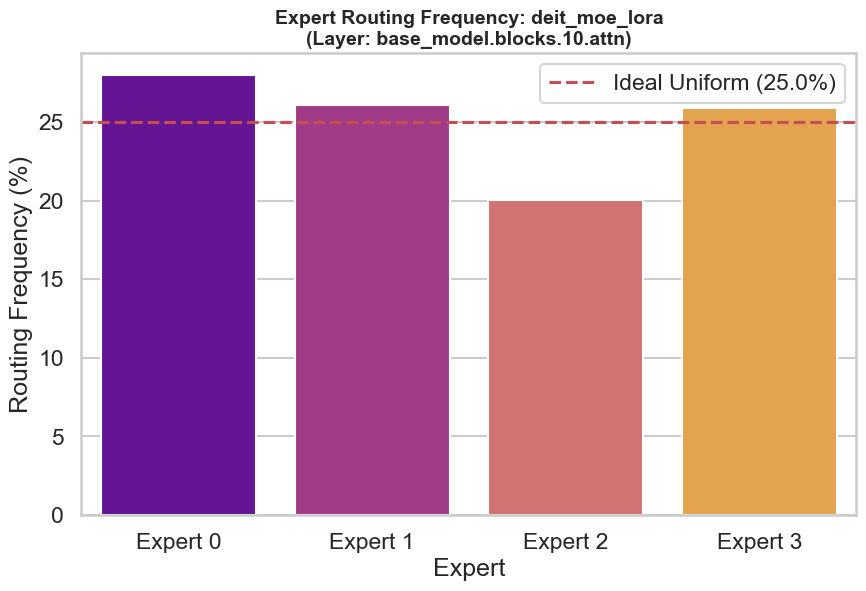

C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


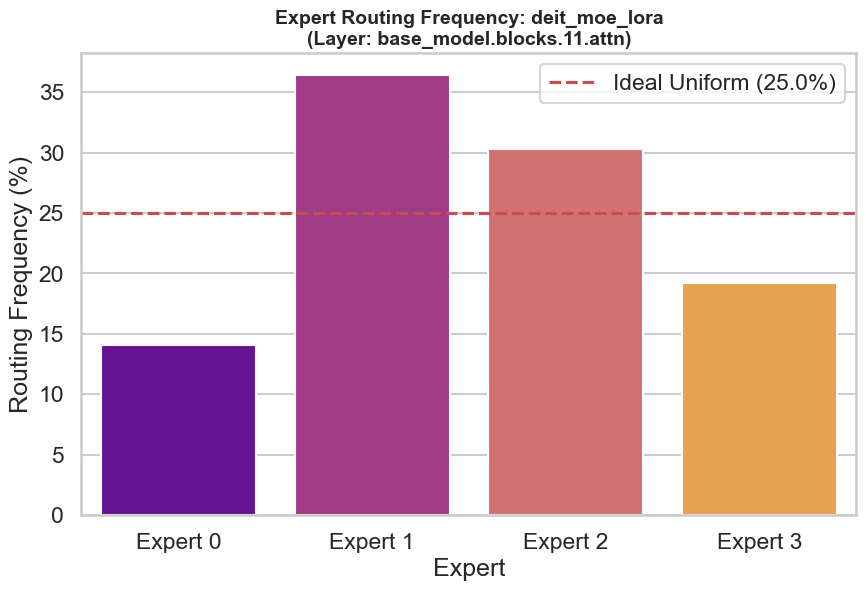

C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


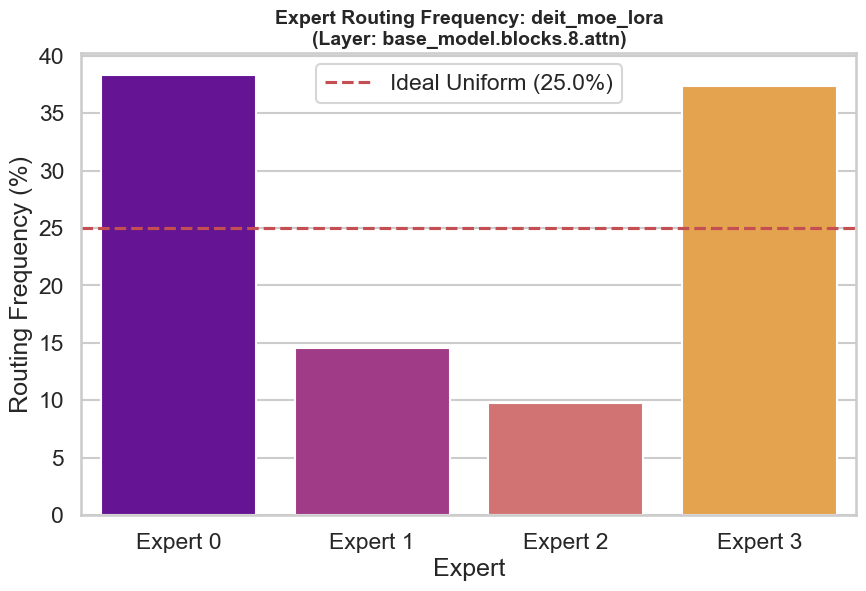

C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


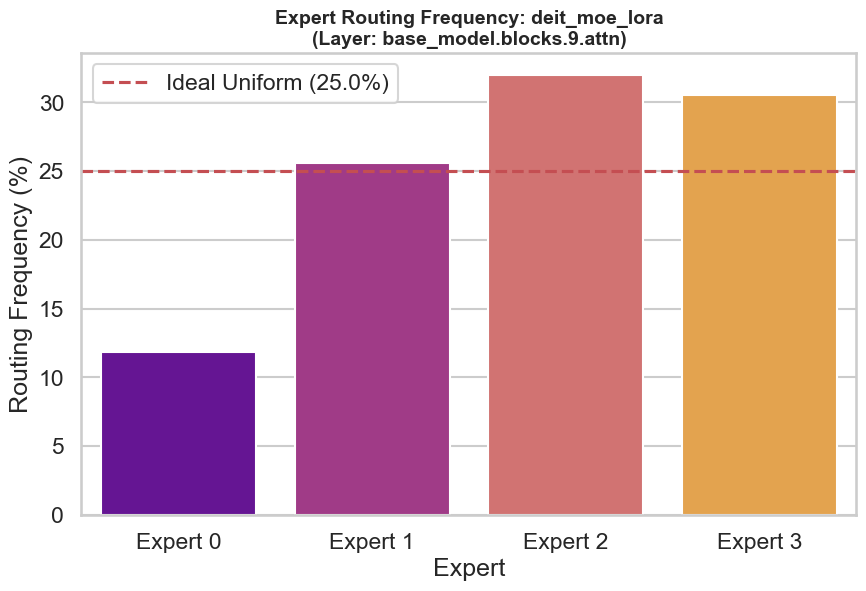


--- Diagnostics for vit_moe_lora (ViT-Small) ---
  Found 4 MoE layers: ['base_model.blocks.10.attn', 'base_model.blocks.11.attn', 'base_model.blocks.8.attn', 'base_model.blocks.9.attn']


C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


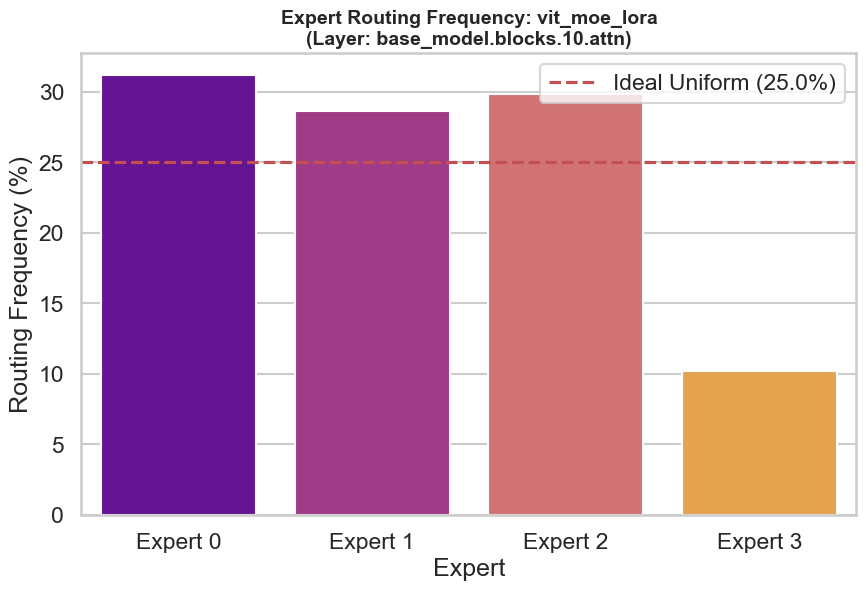

C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


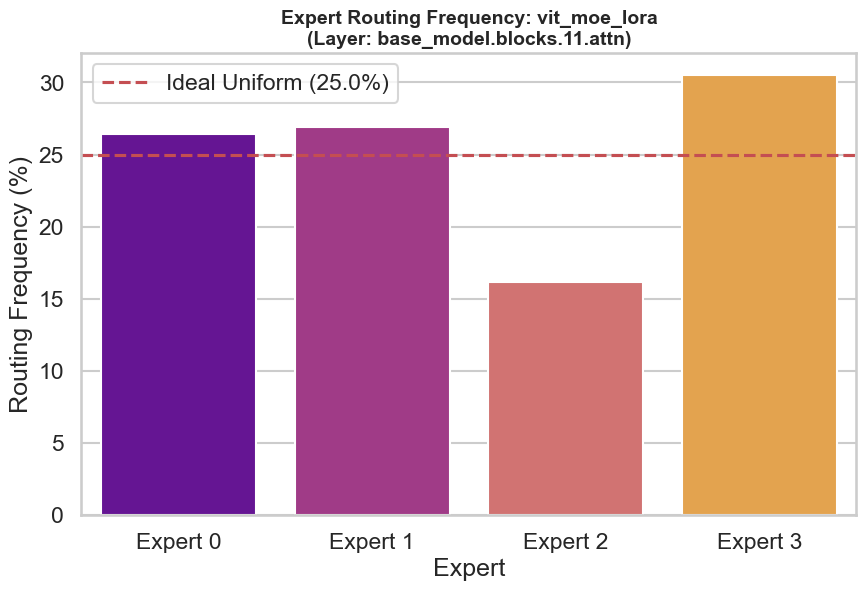

C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


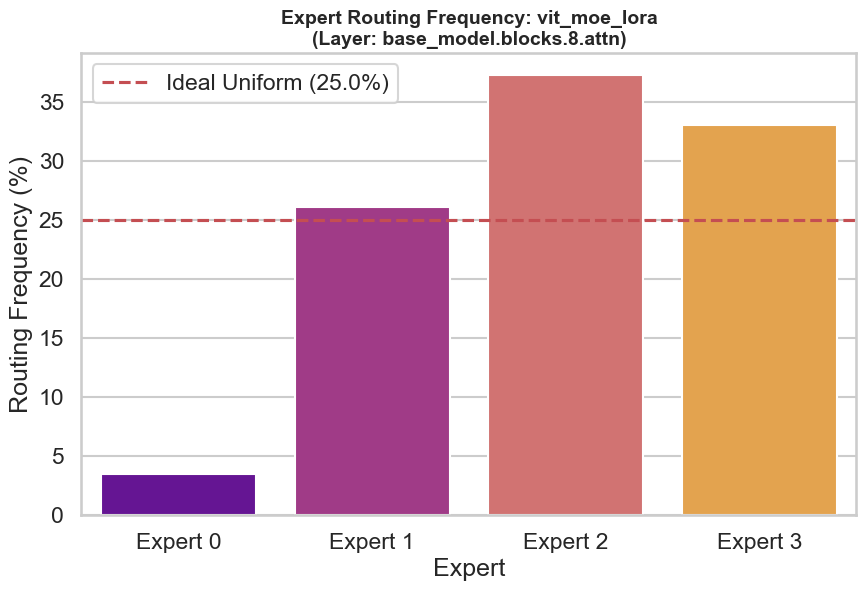

C:\Users\Nevan\AppData\Local\Temp\ipykernel_58524\3972612433.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")


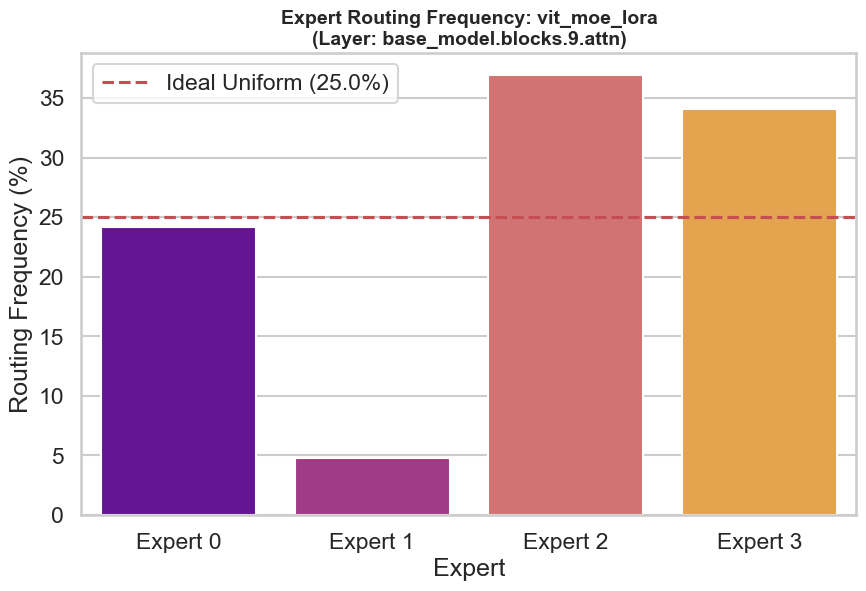

In [34]:
moe_experiments = [name for name in EXPERIMENT_NAMES if "moe_lora" in name]

for exp_name in moe_experiments:
    diag_path = LOGS_DIR / exp_name / "routing_diagnostics.npz"
    backbone_name = "DeiT-Small" if "deit" in exp_name else "ViT-Small"

    if not diag_path.exists():
        print(f"\n--- Diagnostics for {exp_name} ({backbone_name}) ---")
        print(f"WARNING: 'routing_diagnostics.npz' not found. Run evaluation with --run_diagnostics.")
        continue

    # Load the single NPZ file for the experiment
    routing_data = np.load(diag_path)

    # --- NEW: Discover all layers stored in the file ---
    layer_names = set()
    for key in routing_data.files:
        if key.endswith('_indices'):
            # e.g., 'blocks.8.attn_indices' -> 'blocks.8.attn'
            layer_name = key.rsplit('_', 1)[0]
            layer_names.add(layer_name)

    layer_names = sorted(list(layer_names))
    print(f"\n--- Diagnostics for {exp_name} ({backbone_name}) ---")
    print(f"  Found {len(layer_names)} MoE layers: {layer_names}")

    # --- NEW: Inner loop to plot diagnostics for EACH layer ---
    for layer_name in layer_names:

        # 1. Construct the keys for this specific layer
        weights_key = f"{layer_name}_weights"
        indices_key = f"{layer_name}_indices"

        # 2. Extract the data for this layer
        try:
            top_k_indices = routing_data[indices_key]
        except KeyError:
            print(f"  WARNING: Could not find key '{indices_key}' in {diag_path}. Skipping layer.")
            continue

        # 3. Infer num_experts from the data itself
        num_experts = int(top_k_indices.max() + 1)

        # 4. Get the raw frequency of each expert being chosen
        expert_ids, counts = np.unique(top_k_indices.flatten(), return_counts=True)
        total_choices = len(top_k_indices.flatten())
        routing_frequency = (counts / total_choices) * 100

        # 5. Create a DataFrame for robust seaborn plotting
        # This ensures all experts (0 to num_experts-1) are shown, even if one has 0 count
        expert_df = pd.DataFrame({'Expert Index': range(num_experts), 'Routing Frequency (%)': 0.0})
        freq_map = dict(zip(expert_ids, routing_frequency))
        expert_df['Routing Frequency (%)'] = expert_df['Expert Index'].map(freq_map).fillna(0.0)
        expert_df['Expert'] = expert_df['Expert Index'].apply(lambda x: f"Expert {x}")

        # 6. Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=expert_df, x='Expert', y='Routing Frequency (%)', palette="plasma")
        plt.title(f"Expert Routing Frequency: {exp_name}\n(Layer: {layer_name})", fontsize=14, weight='bold')
        plt.ylabel("Routing Frequency (%)")

        # The ideal frequency for any given choice is 1/N.
        ideal_perc = 100 / num_experts
        plt.axhline(ideal_perc, color='r', linestyle='--', label=f'Ideal Uniform ({ideal_perc:.1f}%)')
        plt.legend()
        plt.show()

## Training History Plotting

In [35]:
all_history_data = []
for exp_name in EXPERIMENT_NAMES:
    try:
        history_file = next(LOGS_DIR.glob(f"{exp_name}/*_history.csv"))
        df = pd.read_csv(history_file)

        # Add identifiers
        df['Experiment'] = exp_name
        df['Backbone'] = "DeiT-Small" if "deit" in exp_name else "ViT-Small"
        if "full_finetune" in exp_name: df['Method'] = "Full Fine-Tune"
        elif "linear_probe" in exp_name: df['Method'] = "Linear Probe"
        elif "moe_lora" in exp_name: df['Method'] = "MoE LoRA"
        elif "static_lora" in exp_name: df['Method'] = "Static LoRA"
        else: df['Method'] = "Unknown"

        all_history_data.append(df)
    except StopIteration:
        print(f"Warning: No history file found for {exp_name}. Skipping.")

history_df_full = pd.concat(all_history_data).reset_index().rename(columns={"index": "Epoch"})
history_df_full['Epoch'] = history_df_full['Epoch'] + 1 # 1-based indexing

print("Full training history data loaded.")
display(history_df_full.head())

Full training history data loaded.


,Epoch,train_loss,val_loss,train_acc,val_acc,train_aux_loss,Experiment,Backbone,Method
0,1,4.006824,3.990813,2.393617,1.861702,0.0,deit_full_finetune,DeiT-Small,Full Fine-Tune
1,2,3.959152,3.861516,2.765957,3.297872,0.0,deit_full_finetune,DeiT-Small,Full Fine-Tune
2,3,3.842570,3.657824,4.946809,9.787234,0.0,deit_full_finetune,DeiT-Small,Full Fine-Tune
3,4,3.678089,3.353300,13.829787,24.946809,0.0,deit_full_finetune,DeiT-Small,Full Fine-Tune
4,5,3.339737,2.868130,31.702128,40.000000,0.0,deit_full_finetune,DeiT-Small,Full Fine-Tune


## Loss Plotting

--- Generating Individual Loss Curves (Train vs. Val) ---


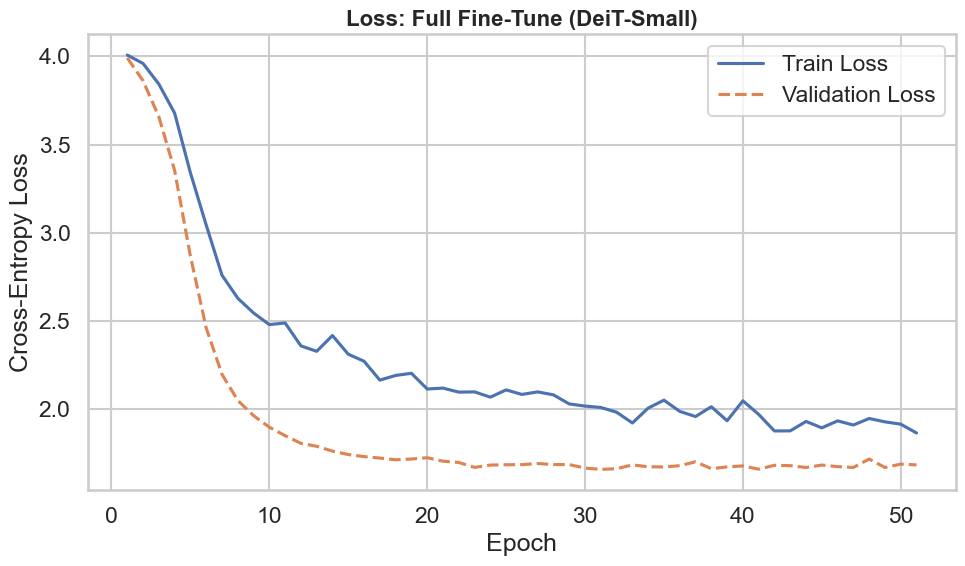

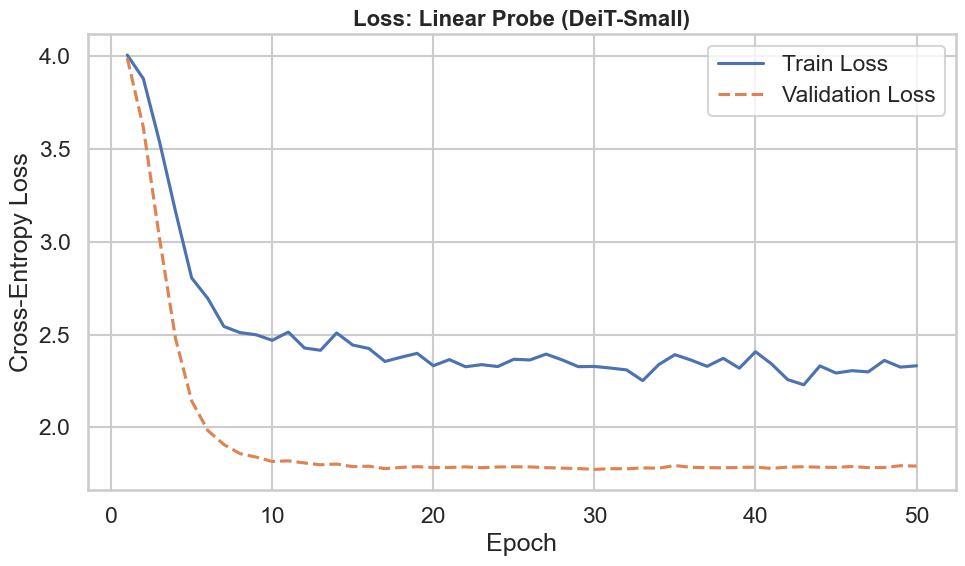

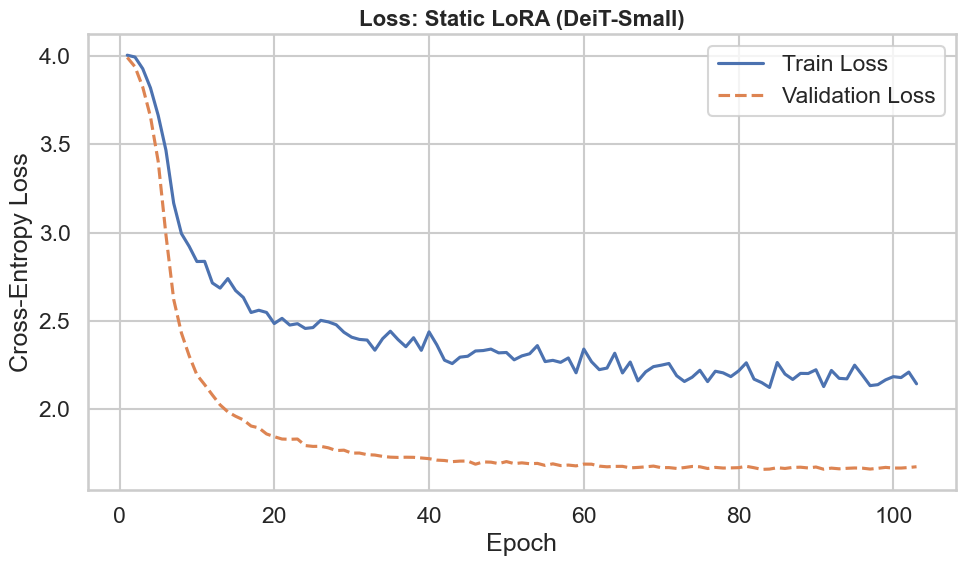

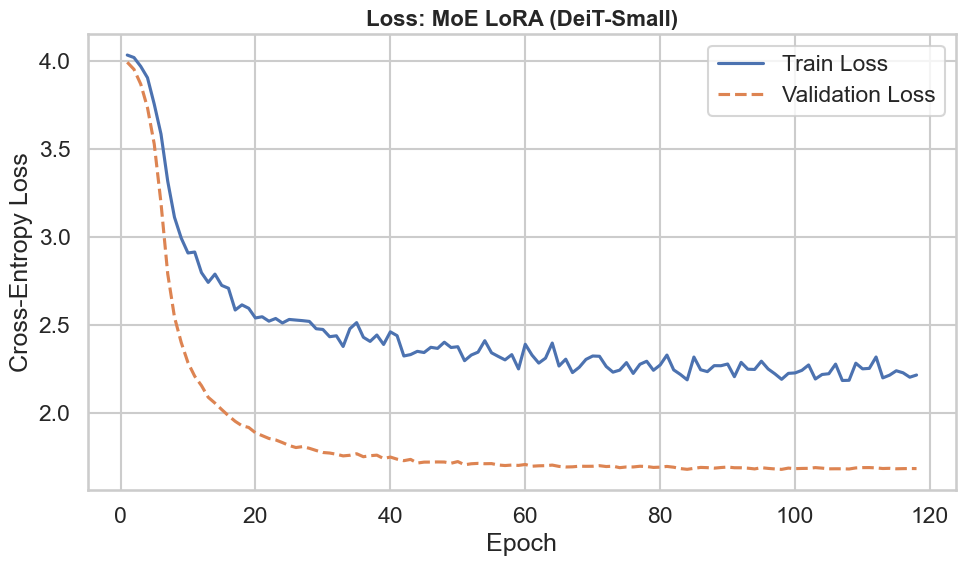

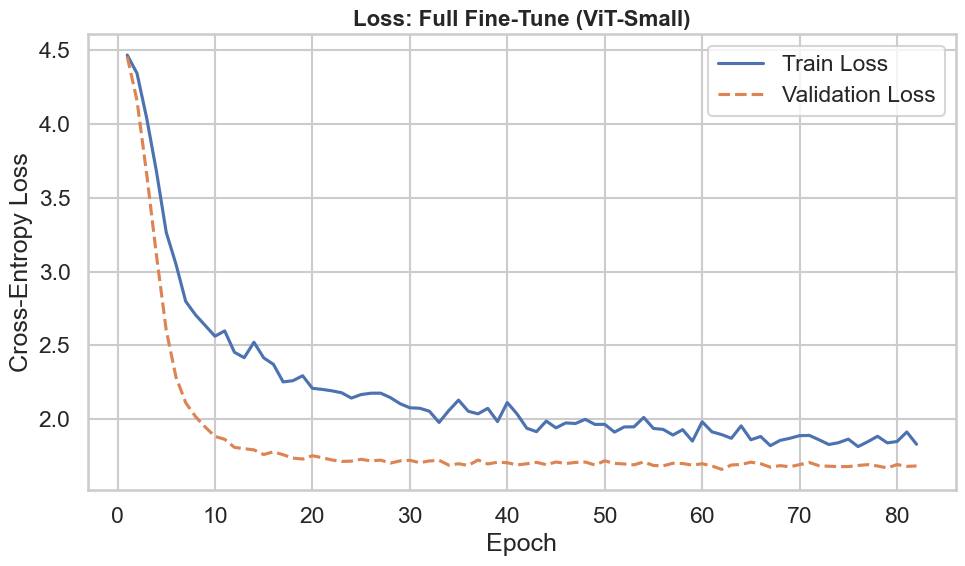

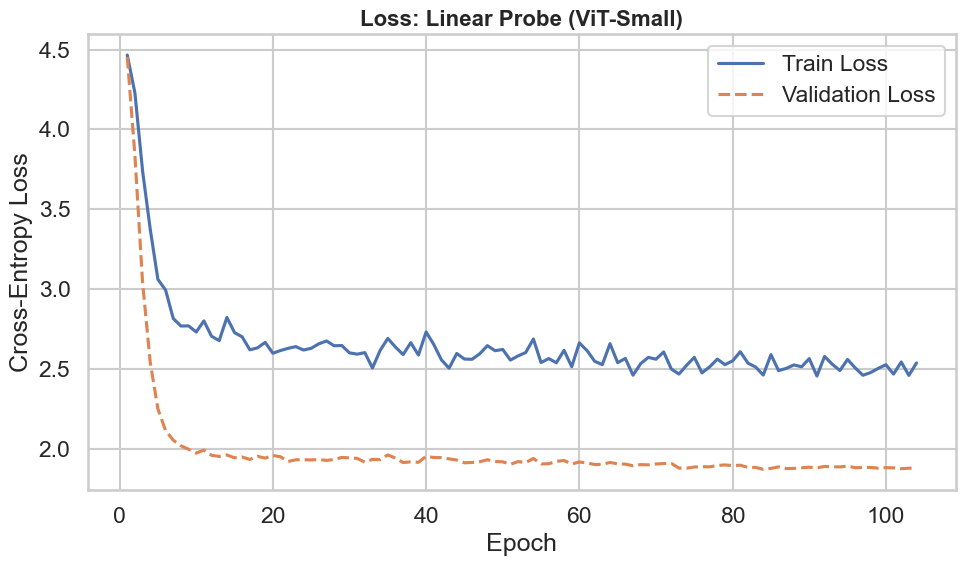

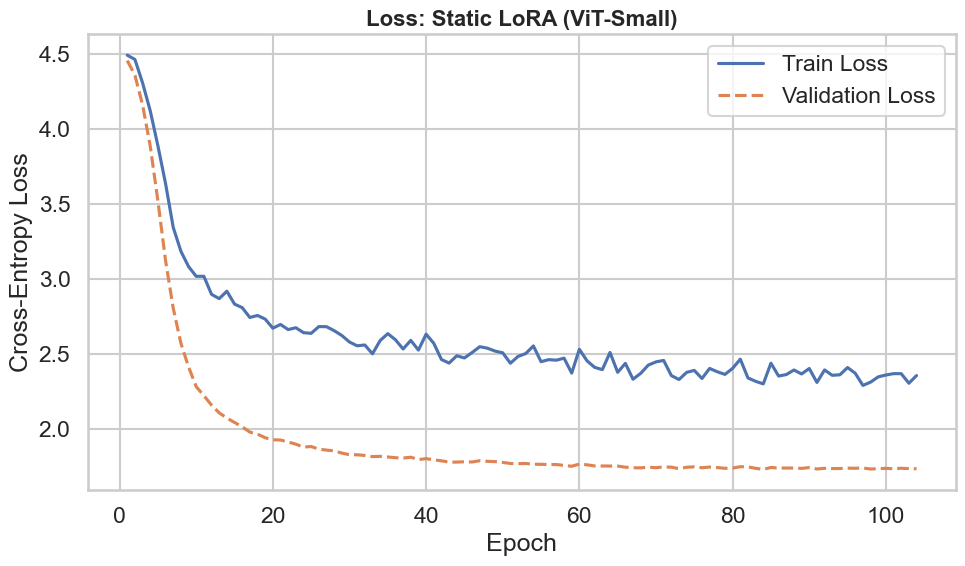

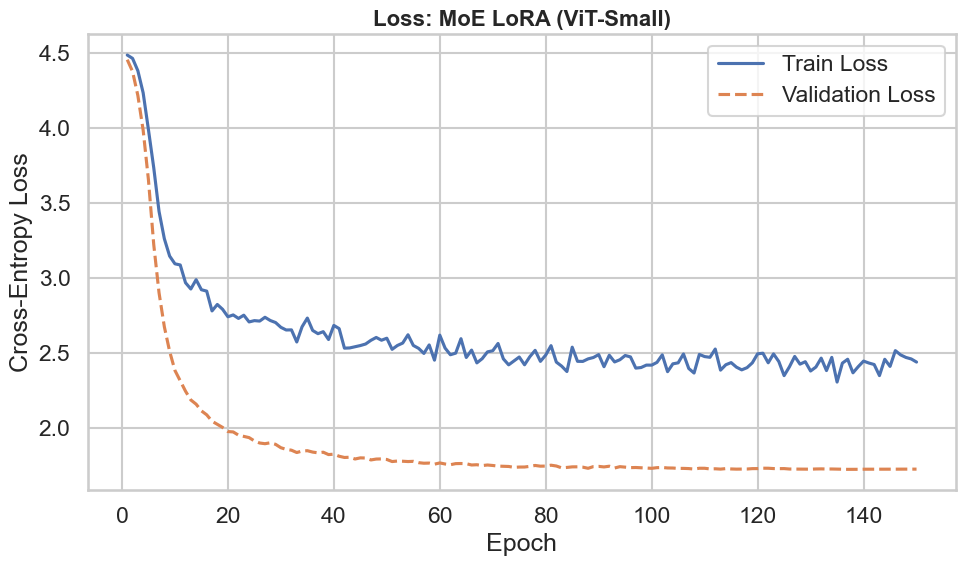


--- Generating Individual Accuracy Curves (Train vs. Val) ---


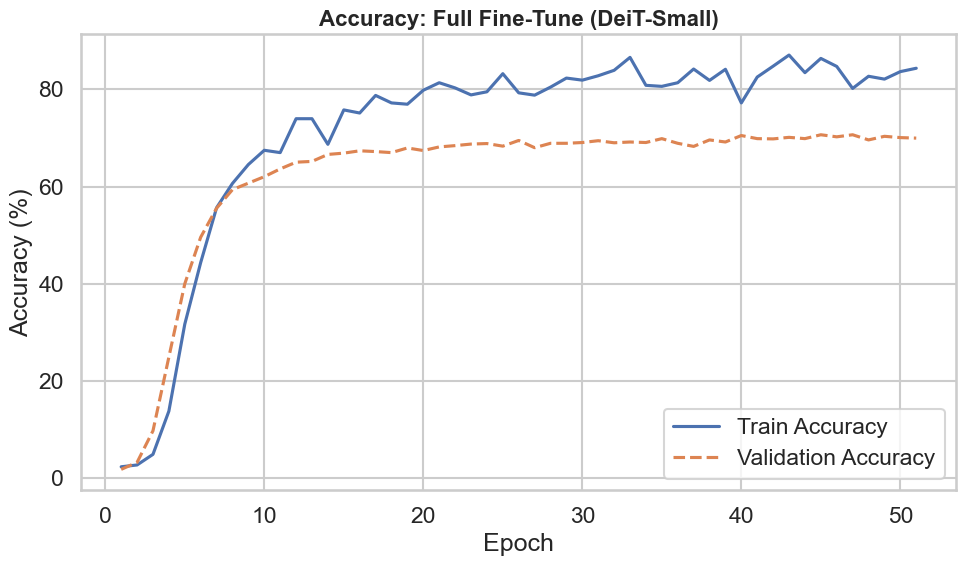

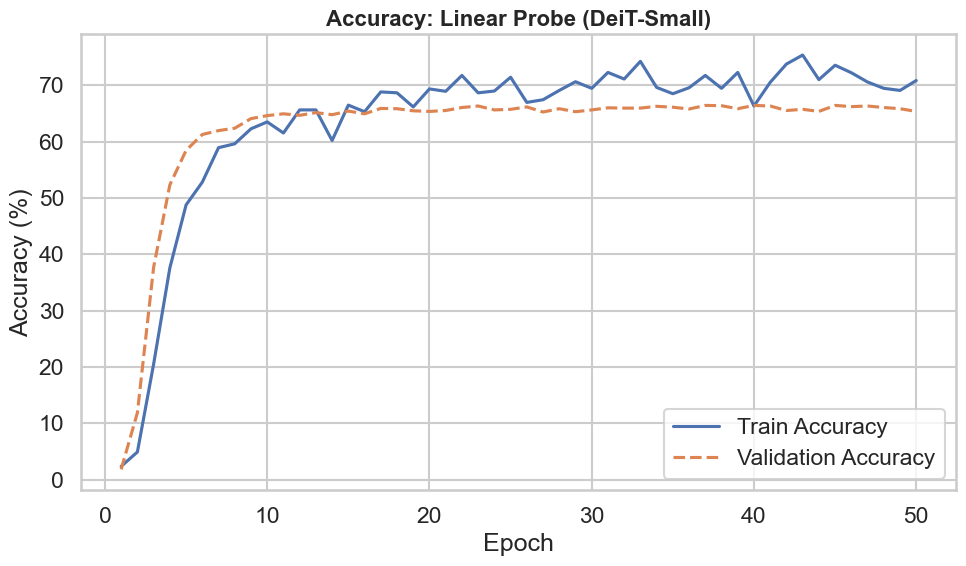

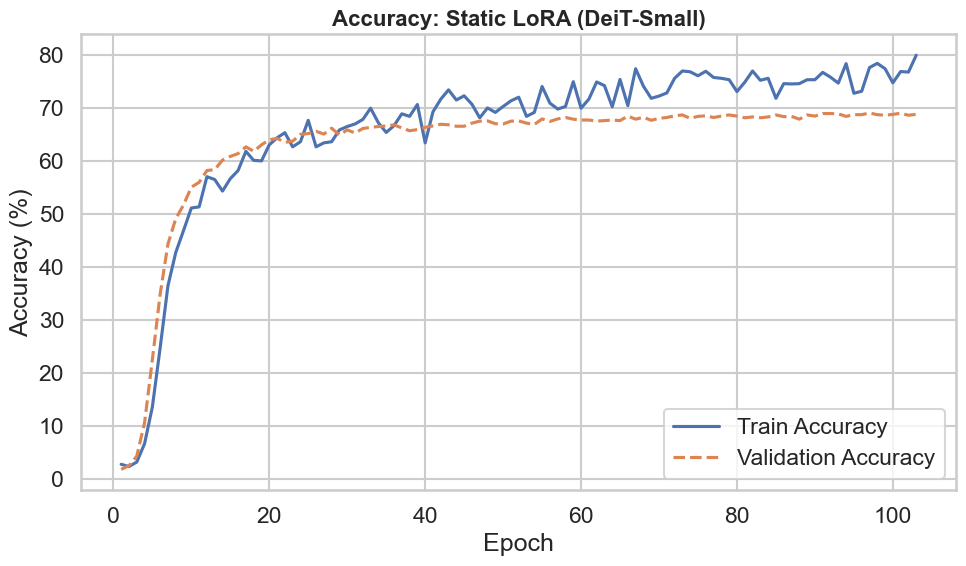

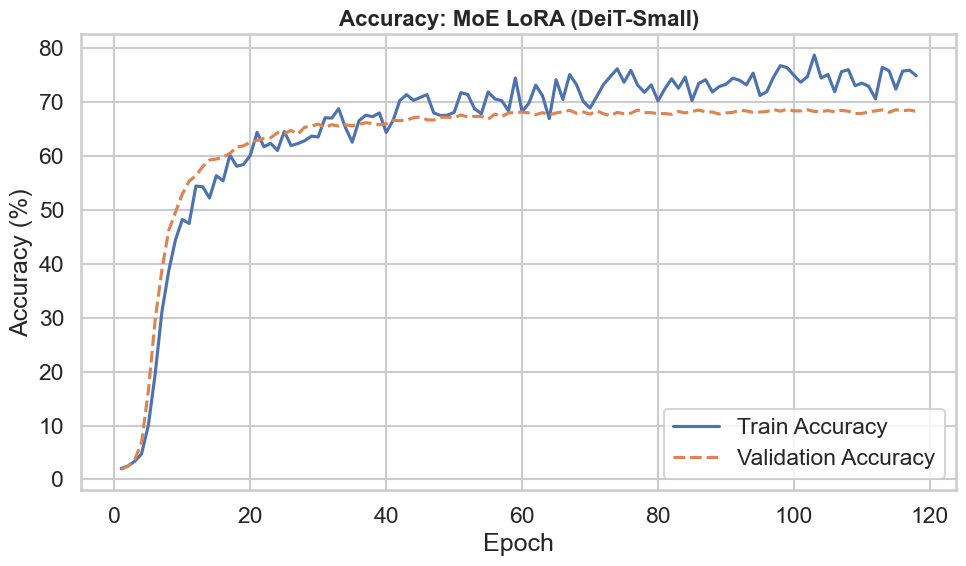

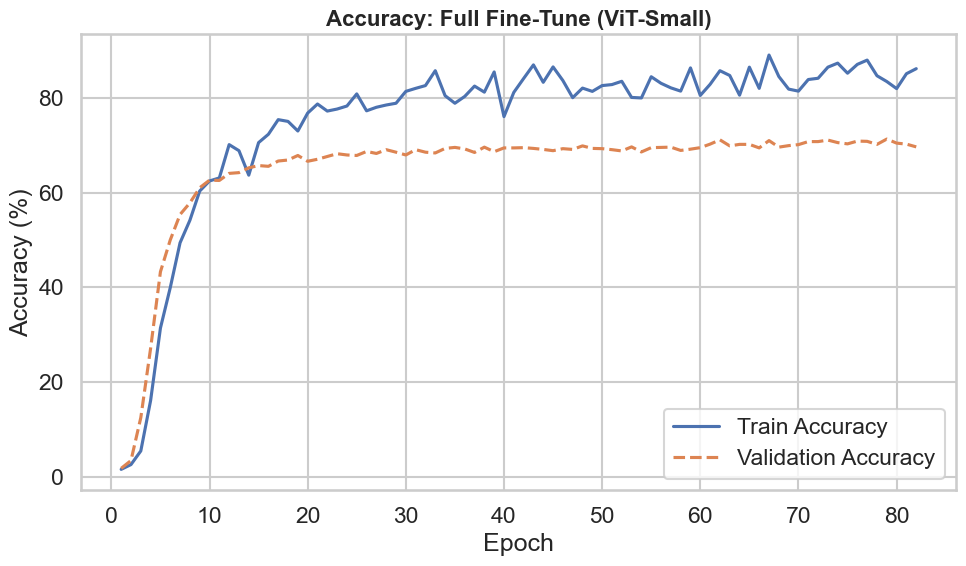

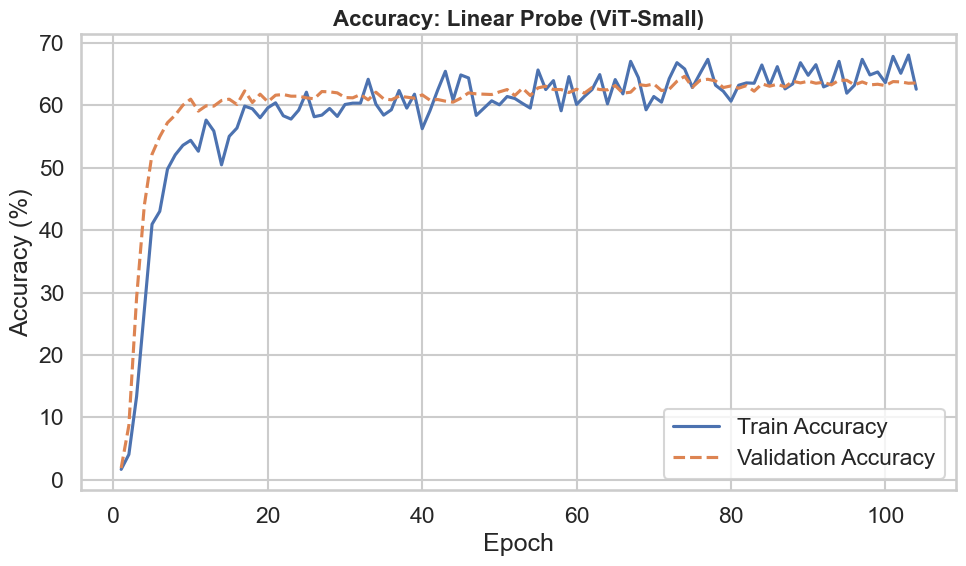

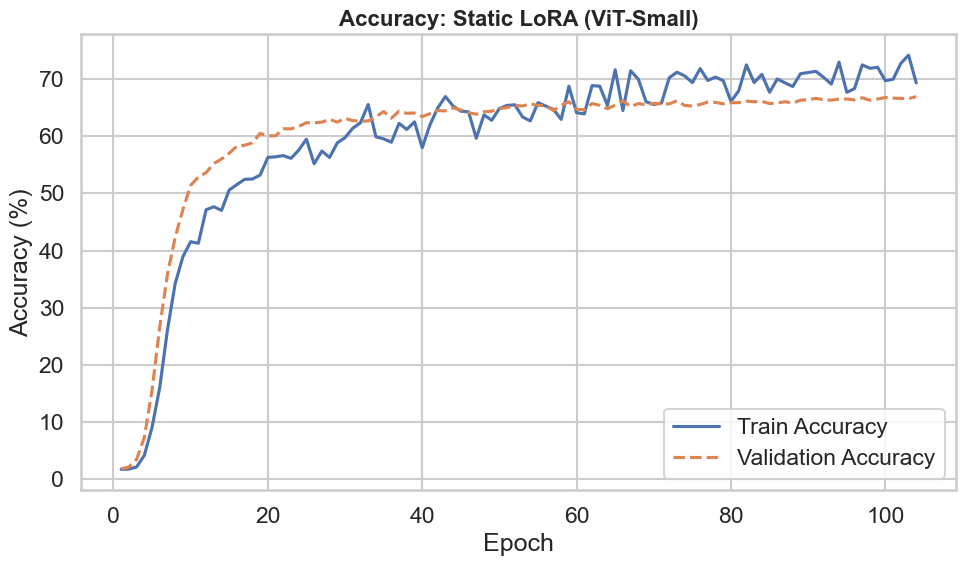

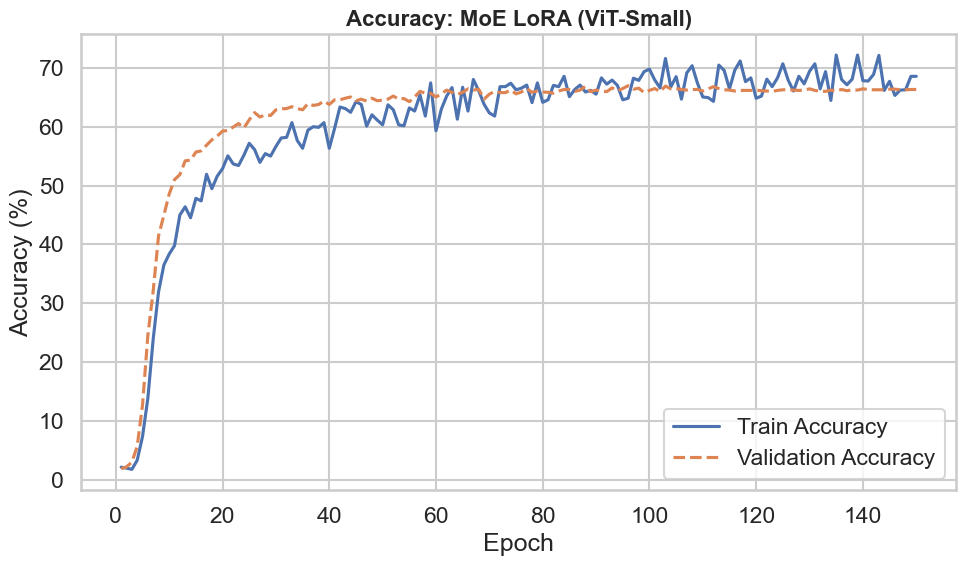

In [36]:
print("--- Generating Individual Loss Curves (Train vs. Val) ---")
for exp_name in EXPERIMENT_NAMES:
    exp_df = history_df_full[history_df_full['Experiment'] == exp_name]
    if exp_df.empty:
        continue

    backbone = exp_df['Backbone'].iloc[0]
    method = exp_df['Method'].iloc[0]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=exp_df, x='Epoch', y='train_loss', label='Train Loss')
    sns.lineplot(data=exp_df, x='Epoch', y='val_loss', label='Validation Loss', linestyle='--')

    plt.title(f"Loss: {method} ({backbone})", fontsize=16, weight='bold')
    plt.ylabel("Cross-Entropy Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()
# --- Plot 2: Training vs. Validation Accuracy (Separated by Experiment) ---
# This plot also shows overfitting for each model individually

print("\n--- Generating Individual Accuracy Curves (Train vs. Val) ---")
for exp_name in EXPERIMENT_NAMES:
    exp_df = history_df_full[history_df_full['Experiment'] == exp_name]
    if exp_df.empty:
        continue

    backbone = exp_df['Backbone'].iloc[0]
    method = exp_df['Method'].iloc[0]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=exp_df, x='Epoch', y='train_acc', label='Train Accuracy')
    sns.lineplot(data=exp_df, x='Epoch', y='val_acc', label='Validation Accuracy', linestyle='--')

    plt.title(f"Accuracy: {method} ({backbone})", fontsize=16, weight='bold')
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Auxiliary Loss Plotting

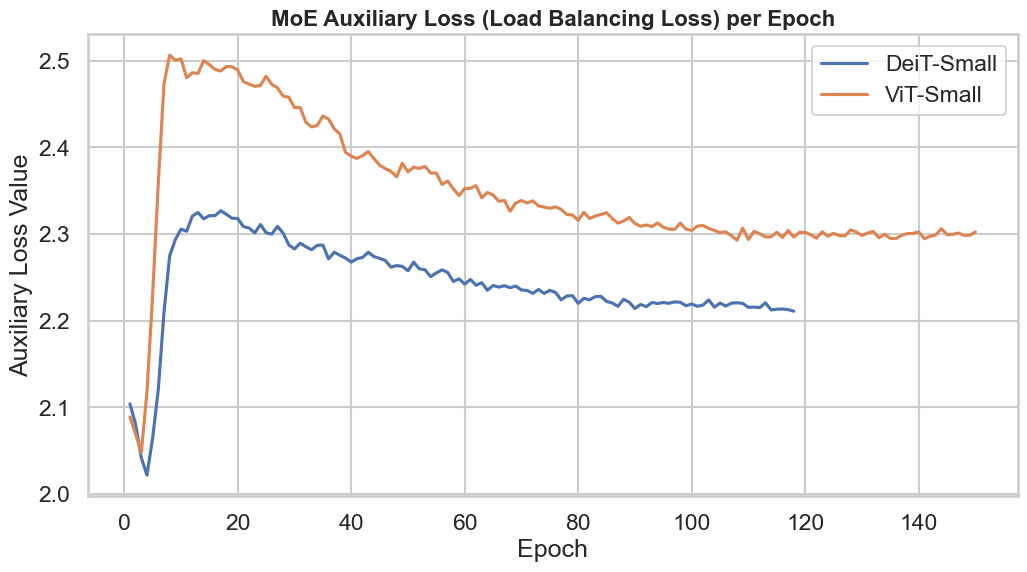

In [37]:
# Filter for MoE experiments only
moe_history_df = history_df_full[history_df_full['Method'] == 'MoE LoRA']

plt.figure(figsize=(12, 6))
sns.lineplot(data=moe_history_df, x='Epoch', y='train_aux_loss', hue='Backbone')
plt.title("MoE Auxiliary Loss (Load Balancing Loss) per Epoch", fontsize=16, weight='bold')
plt.ylabel("Auxiliary Loss Value")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Accuracy Plotting

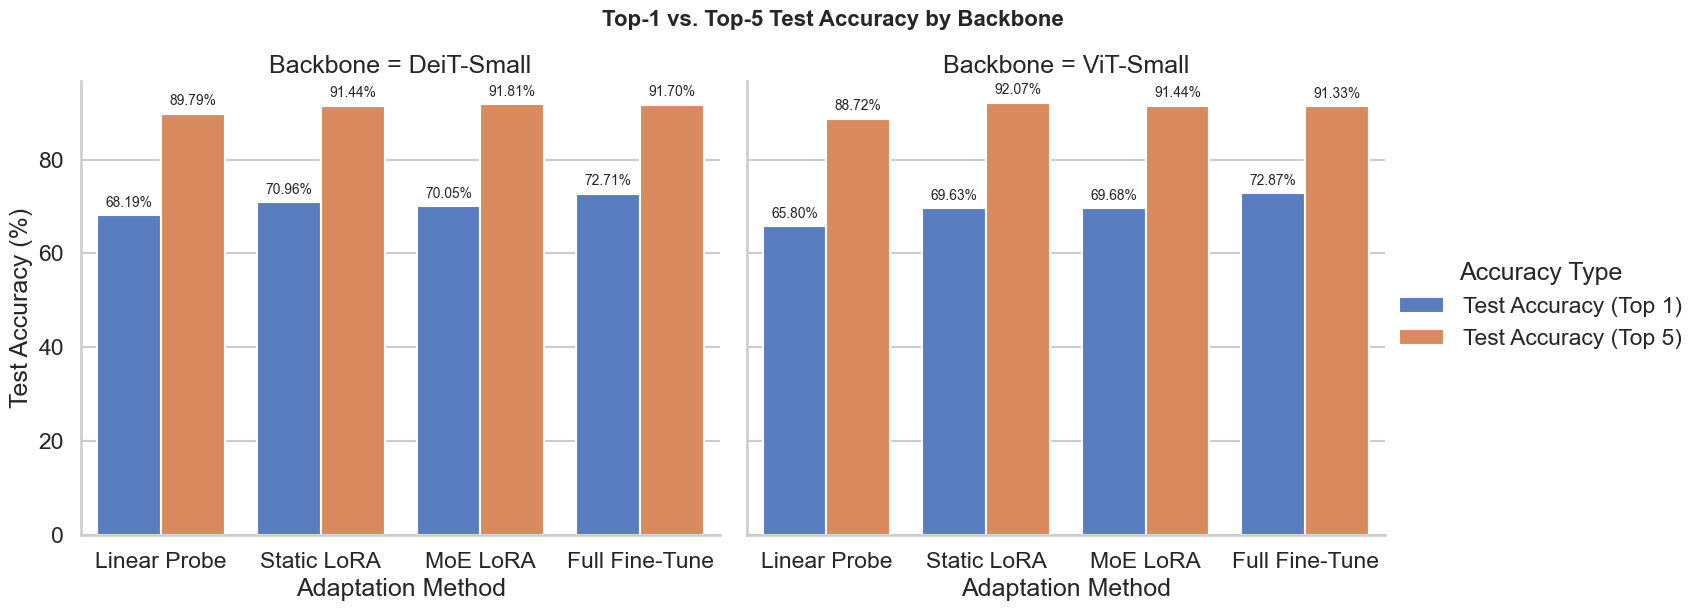

In [38]:
# Melt the DataFrame for easier plotting with seaborn
results_df_melted = results_df.melt(
    id_vars=['Experiment', 'Backbone', 'Method'],
    value_vars=['Test Accuracy (Top 1)', 'Test Accuracy (Top 5)'],
    var_name='Accuracy Type',
    value_name='Accuracy (%)'
)

# Facet by Backbone for a clean comparison
g = sns.catplot(
    data=results_df_melted,
    x='Method',
    y='Accuracy (%)',
    hue='Accuracy Type',
    col='Backbone',
    kind='bar',
    order=["Linear Probe", "Static LoRA", "MoE LoRA", "Full Fine-Tune"],
    palette='muted',
    height=6,
    aspect=1.2
)

g.fig.suptitle("Top-1 vs. Top-5 Test Accuracy by Backbone", y=1.03, fontsize=16, weight='bold')
g.set_axis_labels("Adaptation Method", "Test Accuracy (%)")

# Add annotations
for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f"{p.get_height():.2f}%",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points',
                        fontsize=10)
plt.show()